In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import tensorflow as tf
import numpy as np
import pickle
import json
from sklearn.model_selection import train_test_split
import argparse
from tensorflow.contrib import layers
from tensorflow.contrib import rnn
from tensorflow.contrib import seq2seq
from seq2seq.rnn_seq2seq import DynamicSeq2Seq
from seq2seq.batch_utils import time_major_batch

In [4]:
with open("data/pph1_enc.pkl", "rb") as fout:
    pph1_enc = pickle.load(fout)
with open("data/pph2_enc.pkl", "rb") as fout:
    pph2_enc = pickle.load(fout)
with open("data/pph_vocab.txt") as fin:
    vocab = fin.readlines()
with open("data/token2id.json") as fout:
    token2id = json.load(fout)
with open("data/id2token.json") as fout:
    id2token = json.load(fout)
    id2token = {int(key):value for key, value in id2token.items()}

unk_id = 2
unk = " "
encode = lambda line: list(map(lambda t: token2id.get(t, unk_id), line))
decode = lambda line: "".join(list(map(lambda i: id2token.get(i, unk), line)))

indices = np.arange(len(pph1_enc))
train_ids, val_ids = train_test_split(indices, test_size=0.2, random_state=42)

train_input = [pph1_enc[i] for i in train_ids]
train_target = [pph2_enc[i] for i in train_ids]
train_data = list(zip(train_input, train_target))

val_input = [pph1_enc[i] for i in val_ids]
val_target = [pph2_enc[i] for i in val_ids]
val_data = list(zip(val_input, val_target))

vocab_size = len(vocab) + 3
emb_size = 64

encoder_args = {
    "cell": rnn.LSTMCell(512),
    "bidirectional": False,
}

decoder_args = {
    "cell": rnn.LSTMCell(512),
    "attention": True,
}

model = DynamicSeq2Seq(
    vocab_size, emb_size, encoder_args, decoder_args)

gpu_option = 0.25
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_option)

In [5]:
def inference(query):
    try:
        assert isinstance(query, str)
        query = encode(query)
    except:
        assert isinstance(query, list)
        assert isinstance(query[0], int)
    query_batch, query_batch_len = time_major_batch([query])
    predicted = sess.run(
        model.decoder.inference_prediction, 
        feed_dict={
            model.encoder.inputs: query_batch, 
            model.encoder.inputs_length: query_batch_len}).reshape(-1)
    predicted_line = decode(predicted)
    return predicted_line

In [6]:
# def softmax(x):
#     e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum()

In [7]:
# def inference_with_temperature(query, temperature=1.0):
#     try:
#         assert isinstance(query, str)
#         query = encode(query)
#     except:
#         assert isinstance(query, list)
#         assert isinstance(query[0], int)
#     query_batch, query_batch_len = time_major_batch([query])
#     predicted_logits = sess.run(
#         model.decoder.inference_logits, 
#         feed_dict={
#             model.encoder.inputs: query_batch, 
#             model.encoder.inputs_length: query_batch_len})
#     predicted_logits = np.squeeze(predicted_logits, axis=(1,))
#     predicted_probs = [softmax(row) for row in predicted_logits]
#     predicted_probs = np.vstack([p ** temperature / np.sum(p ** temperature) for p in predicted_probs])
#     predicted = [np.random.choice(np.arange(len(row)), p=row) for row in predicted_probs]
#     predicted_line = decode(predicted)
#     return predicted_line

In [8]:
# beam_decodered = tf.nn.ctc_beam_search_decoder(
#     model.decoder.inference_logits,
#     model.decoder.encoder_inputs_length + 3,
#     top_paths=5, 
#     merge_repeated=False)
# def inference_with_beam(query):
#     try:
#         assert isinstance(query, str)
#         query = encode(query)
#     except:
#         assert isinstance(query, list)
#         assert isinstance(query[0], int)
#     query_batch, query_batch_len = time_major_batch([query])
#     import pdb; pdb.set_trace()
#     decoded, log_probs = sess.run(
#         beam_decodered, 
#         feed_dict={
#             model.encoder.inputs: query_batch, 
#             model.encoder.inputs_length: query_batch_len})
#     log_probs = np.squeeze(log_probs, axis=0)
#     predicted_line = "\n".join([
#         "{:.3f} : {}".format(prob, decode(decod.values)) 
#         for decod, prob in zip(decoded, np.exp(log_probs))])
#     return predicted_line

In [9]:
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [10]:
saver = tf.train.Saver()

In [11]:
saver.restore(sess, "./logs_170424_test_forward/model/10/model.cpkl")

In [12]:
data_of_interest = np.random.randint(len(val_data), size=10)

In [13]:
for i in data_of_interest:
    query, target = val_data[i]
    try:
        print("\n".join((decode(query), inference(query), decode(target))))
    except:
        print("\n".join((query, inference(query))))
    print("-"*80)

What is the best place for a honeymoon in February? 
What are the best places to hangout in February?  
What is the best place to honeymoon in February? 
--------------------------------------------------------------------------------
How should I make money online for free? 
How can I make money online for free?  
How can I make money online with free of cost? 
--------------------------------------------------------------------------------
Which are the most beautiful photos of Spiders and/or Spiderwebs you've seen? 
What are some of the best photos you have seen?  
Spiders: What are some of the most beautiful photos of spiderwebs? 
--------------------------------------------------------------------------------
What are the top challenges cybersecurity faces today? 
What are the best challenges today cybersecurity?  
What are the top cybersecurity challenges? 
--------------------------------------------------------------------------------
How can I prepare for gate? 
How do I prepa

In [38]:
# np.random.seed(42)
# query, target = val_data[data_of_interest[1]]
# print(decode(query))
# print("-"*80)
# print(inference(query))
# print("-"*80)
# for seed in np.random.randint(42, 10000, size=10):
#     np.random.seed(seed)
#     print(inference_with_temperature(query, 1.))
# print("-"*80)
# print(decode(target))

What will you change if you get a chance to go back in a past? 
--------------------------------------------------------------------------------
What would you do if you get a chance to go back in the past?  
--------------------------------------------------------------------------------
What iiuld you do if you get n chance to go fack in cwe past?  
Chat would bou do if you bet c chance to go back in?the aast?  
What could bou do if you set a chance to go back in the past   
What Iould you do df you'get r chance to go back tn Uhi cast?  
What dould you do if you get r chance to go back an 8he dast?  
What could you eo if you vet b chance to go back in tie sast?  
Ihat would you do if you het p chance to go?back tn mhe mast?  
What wiuld you do if you cet d chance to go fack tn phr Aast?  
What wiuld you do if you Get a chance to go back in mir wast?  
What wiuld tou do if you get c chance to go back in the cast?  
----------------------------------------------------------------------

In [14]:
# for i in data_of_interest:
#     query, target = val_data[i]
#     try:
#         print("\n".join((decode(query), inference_with_temperature(query, .5), decode(target))))
#     except:
#         print("\n".join((query, inference(query))))
#     print("-"*80)

What is the best place for a honeymoon in February? 
What irp she dest rlaced to lavgotn if FebRuary?  
What is the best place to honeymoon in February? 
--------------------------------------------------------------------------------
How should I make money online for free? 
How Dan I eake aoney online?iar bree?  
How can I make money online with free of cost? 
--------------------------------------------------------------------------------
Which are the most beautiful photos of Spiders and/or Spiderwebs you've seen? 
Whit are some nf She hest photos,oou aave eeen   
Spiders: What are some of the most beautiful photos of spiderwebs? 
--------------------------------------------------------------------------------
What are the top challenges cybersecurity faces today? 
Dhot'bre 5he hest challenges?lhdaysclbersegurity?  
What are the top cybersecurity challenges? 
--------------------------------------------------------------------------------
How can I prepare for gate? 
Wow do y seepa

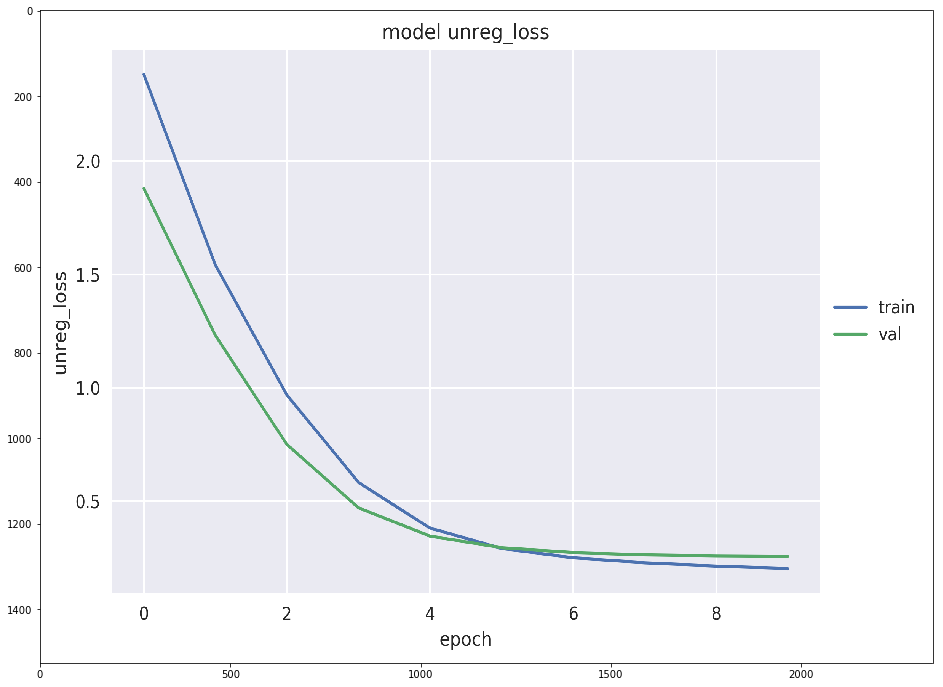

In [10]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open("./logs_170424_test_forward/model/10/plotter/unreg_loss.png", 'r')
figure(figsize = (16,12))
imshow(np.asarray(pil_im), interpolation='nearest', aspect='auto')